In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [58]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

client = bigquery.Client()

/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Get top purchased listings for each query, aggregating 1 month data

In [4]:
%%bigquery query_df
with query_with_purchased_listing as (
    select distinct query, listing_id, purchases
    from `etsy-data-warehouse-prod.search.visit_level_listing_impressions`
    where _date between date('2023-05-01') and date('2023-05-31')
    and page in ('search', 'market')
    and purchases > 0
)
select query, listing_id, sum(purchases) as purchases
from query_with_purchased_listing
group by query, listing_id
order by query, purchases desc

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
query_df.head()

,query,listing_id,purchases
0,!*i20,1458746513,1
1,"""""",513278436,56
2,"""""",978590693,47
3,"""""",1343525011,37
4,"""""",1453421847,37


In [6]:
print(f"query_df.shape[0]: {query_df.shape[0]}")
print(f"Number of distinct queries: {len(query_df['query'].unique())}")

query_df.shape[0]: 4449687
Number of distinct queries: 2171464


In [8]:
print("Number of purchased listing for each query")
n_purchased_listings_by_query = query_df["query"].value_counts()
n_purchased_listings_by_query.head(n=20)

Number of purchased listing for each query


query
""                           569885
mother day gift                1624
father day gift                1592
svg                            1164
sticker                        1035
father day                      916
gift                            859
mother day                      816
birthday card                   795
father day card                 778
card                            777
graduation gift                 758
necklace                        695
sign                            662
cake topper                     603
crochet pattern                 600
teacher appreciation gift       591
earring                         587
teacher gift                    571
wedding gift                    569
Name: count, dtype: int64

In [45]:
n_distinct_queries = len(query_df['query'].unique())
n_purchased_median = np.median(n_purchased_listings_by_query)

print(f"""Average #listings purchased: {np.mean(n_purchased_listings_by_query)}
Median #listings purchased: {n_purchased_median}""")

Average #listings purchased: 2.0491645267893
Median #listings purchased: 1.0


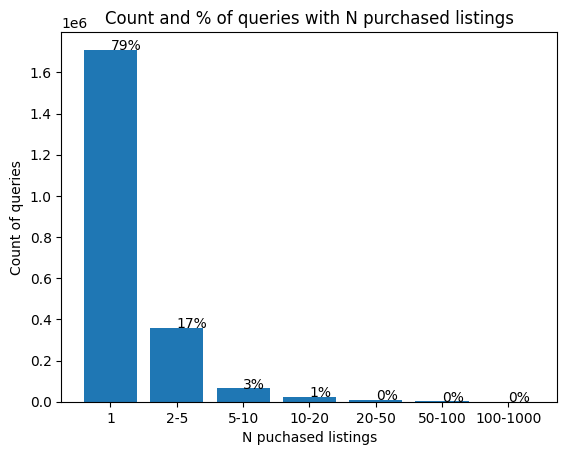

In [10]:
bins = [1, 2, 5, 10, 20, 50, 100, 1000]
bin_labels = ["1", "2-5", "5-10", "10-20", "20-50", "50-100", "100-1000"]

hist_values = np.histogram(n_purchased_listings_by_query, bins = bins)[0]
percentage = ["{0:.0%}".format(x) for x in np.round(hist_values / n_distinct_queries, 5)]

ax = plt.bar(x=bin_labels, height=hist_values)
for x, y, p in zip(bin_labels, hist_values, percentage):
    plt.text(x, y, p)
plt.ylabel("Count of queries")
plt.xlabel("N puchased listings")
plt.title("Count and % of queries with N purchased listings")
plt.show()

# Generate sample data

Assume we use top 1 purchased listing embedding to represent query embedding

In [33]:
from utils import run_query_df

In [40]:
queries_subset = n_purchased_listings_by_query[np.logical_and(
    n_purchased_listings_by_query >= 5, 
    n_purchased_listings_by_query <= 20
)].index
queries_subset = set(queries_subset)
print(f"#queries with 5-20 purchased listings: {len(queries_subset)}")

#queries with 5-20 purchased listings: 90196


In [41]:
selected_queries = np.random.choice(list(queries_subset), size=100, replace=False)
len(selected_queries)

100

100 random queries with 5-20 purchased listings

In [42]:
query_sub_df = query_df[query_df["query"].isin(selected_queries)]
all_relevant_listings = list(query_sub_df.listing_id.unique())

print(query_sub_df.shape)
print(len(query_sub_df["query"].unique()))
print(len(all_relevant_listings))

(830, 3)
100
830


In [43]:
## listing taxonomy
taxo_query_str = f"""
select listing_id, full_path
from `etsy-data-warehouse-prod.materialized.listing_taxonomy`
where listing_id in ({",".join([str(x) for x in all_relevant_listings])})
"""
all_taxo_df = run_query_df(taxo_query_str, project_id="etsy-bigquery-adhoc-prod")
all_taxo_df["tax_top1_node"] = all_taxo_df.full_path.apply(lambda x: x.split(".")[0] if len(x.split(".")) > 1 else x)
all_taxo_df["tax_top2_node"] = all_taxo_df.full_path.apply(lambda x: x.split(".")[1] if len(x.split(".")) > 1 else None)

/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(830, 4)

In [46]:
all_taxo_df.head()

,listing_id,full_path,tax_top1_node,tax_top2_node
0,1160161686,home_and_living.storage_and_organization.toy_s...,home_and_living,storage_and_organization
1,1445395357,clothing.mens_clothing.pants,clothing,mens_clothing
2,1262962812,craft_supplies_and_tools.blanks.jewelry.rings,craft_supplies_and_tools,blanks
3,1462902454,art_and_collectibles.prints.digital_prints,art_and_collectibles,prints
4,962275370,craft_supplies_and_tools.patterns_and_how_to.p...,craft_supplies_and_tools,patterns_and_how_to


In [47]:
all_taxo_df.shape

(830, 4)

In [53]:
curr_df_with_taxo = pd.merge(curr_df, all_taxo_df, on="listing_id")
curr_df_with_taxo.sort_values("purchases", ascending=False, inplace=True)
curr_df_with_taxo

,query,listing_id,purchases,full_path,tax_top1_node,tax_top2_node
0,sloth card,847140468,9,paper_and_party_supplies.paper.invitations_and...,paper_and_party_supplies,paper
1,sloth card,802421415,3,paper_and_party_supplies.paper.greeting_cards....,paper_and_party_supplies,paper
2,sloth card,691409103,2,paper_and_party_supplies.paper.greeting_cards....,paper_and_party_supplies,paper
3,sloth card,986011011,1,paper_and_party_supplies.paper.greeting_cards....,paper_and_party_supplies,paper
4,sloth card,1474020328,1,paper_and_party_supplies.paper.greeting_cards....,paper_and_party_supplies,paper
5,sloth card,841061383,1,paper_and_party_supplies.paper.greeting_cards....,paper_and_party_supplies,paper


In [62]:
data_dic = {}

for qstr in tqdm(selected_queries):
    curr_df = query_sub_df[query_sub_df["query"] == qstr]
    curr_df_with_taxo = pd.merge(curr_df, all_taxo_df, on="listing_id")
    curr_df_with_taxo.sort_values("purchases", ascending=False, inplace=True)
    
    purchased_listings = list(curr_df_with_taxo.listing_id.values)
    
    try:
        assert(len(purchased_listings) == len(np.unique(purchased_listings)))
    except:
        print(qstr)
    
    data_dic[qstr] = {
        "query_embedding_lid": str(purchased_listings[0]),  # ordered by purchase desc in bigquery
        "purchased_listings": purchased_listings,
        "n_purchases": list(curr_df_with_taxo.purchases.values),
        "top_level_taxo": list(curr_df_with_taxo.tax_top1_node.values),
        "2nd_level_taxo": list(curr_df_with_taxo.tax_top2_node.values),
    }

100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.99it/s]


In [69]:
with open('./data/sample_data.pkl', 'wb') as f:
    pickle.dump(data_dic, f, protocol=pickle.HIGHEST_PROTOCOL)

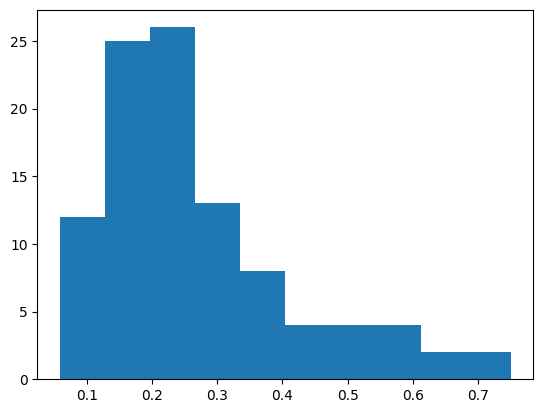

In [75]:
top_level_distrib = [len(set(v["top_level_taxo"])) / len(v["top_level_taxo"])  for v in data_dic.values()]
plt.hist(top_level_distrib)
plt.show()

For every query, purchased listings tend to come from the same top level taxonomy

In [85]:
all_spanned_taxo = set()
for v in data_dic.values():
#     print(set(v["top_level_taxo"]))
    all_spanned_taxo = all_spanned_taxo.union(set(v["top_level_taxo"]))
print(len(all_spanned_taxo))

15


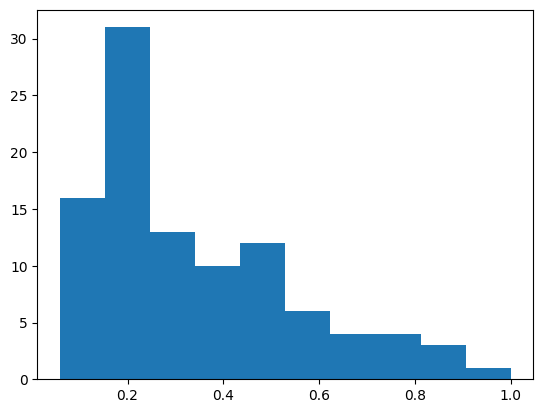

In [87]:
second_level_distrib = [len(set(v["2nd_level_taxo"])) / len(v["2nd_level_taxo"])  for v in data_dic.values()]
plt.hist(second_level_distrib)
plt.show()

**Observations**
+ Majority (80%) queries have only 1 purchased listing, 95% have less than 5 purchased listings
+ For every query, purchased listings tend to come from the same top-level & second-level taxonomy

**Questions**
+ `_date` means date when data is collected?
+ Queries without purchased listings? Find the most "similar" query in the query pool with purchased listings
+ What does value "" mean? - Market visits don't have a query associated, but search page also has it?